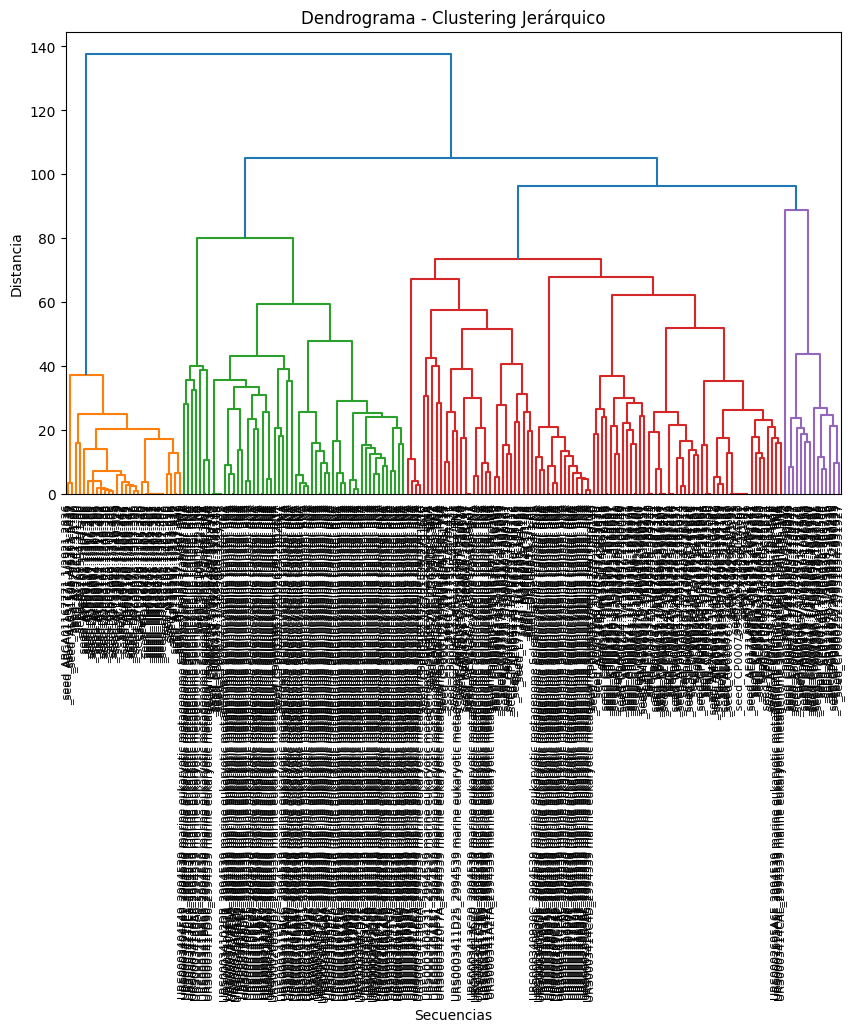


Clustering Jerárquico:
                                                    id  cluster_hierarchical
0                     _seed_CP000112.1/1531804-1531715                     3
1                               _seed_X75790.1/378-471                     3
2                       _seed_AM180252.1/236707-236618                     3
3                     _seed_CP000527.1/2088048-2088137                     3
4                     _seed_AE017285.1/1369596-1369507                     3
..                                                 ...                   ...
369  URS000341FD96_2994539 marine eukaryotic metage...                     2
370  URS000341FEB0_2994539 marine eukaryotic metage...                     2
371  URS000342086C_2994539 marine eukaryotic metage...                     2
372  URS0003420F7A_2994539 marine eukaryotic metage...                     3
373  URS00034210E1_2994539 marine eukaryotic metage...                     2

[374 rows x 2 columns]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# ==============================
# 1. Leer archivo
# ==============================
file = "./3-Folding/rnacentral_fold_nomfe.fasta"
ids, seqs, structs = [], [], []

with open(file, 'r') as f:
    lines = [l.strip() for l in f.readlines()]
    for i in range(0, len(lines), 3):  # id, secuencia, estructura
        ids.append(lines[i].replace(">", ""))
        seqs.append(lines[i+1])
        structs.append(lines[i+2])

df = pd.DataFrame({
    "id": ids,
    "sequence": seqs,
    "structure": structs
})

# ==============================
# 2. Definir mapping
# ==============================
# RNA: a=0, u=1, g=2, c=3
rna_mapping = {'a':0, 'u':1, 'g':2, 'c':3}
# Estructura dot-bracket: .=0, ( =1, )=2
struct_mapping = {'.':0, '(':1, ')':2}

# ==============================
# 3. Convertir secuencia + estructura en vectores de longitud fija
# ==============================
def encode_sequence_structure(seq, struct, max_len):
    """
    Convierte secuencia y estructura a vectores de longitud fija
    """
    seq_vec = [rna_mapping.get(c, -1) for c in seq[:max_len]]  # -1 para caracteres no reconocidos
    struct_vec = [struct_mapping.get(c, -1) for c in struct[:max_len]]

    # Padding con -1 si la longitud es menor
    while len(seq_vec) < max_len:
        seq_vec.append(-1)
    while len(struct_vec) < max_len:
        struct_vec.append(-1)

    return seq_vec + struct_vec  # concatenamos secuencia + estructura

# Aplicar encoding
max_len = 100  # puedes ajustar según tus secuencias
features = df.apply(lambda row: encode_sequence_structure(row['sequence'], row['structure'], max_len), axis=1)
features_df = pd.DataFrame(features.tolist())

# ==============================
# 4. Normalización
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# ==============================
# 5. Clustering jerárquico
# ==============================
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df["id"].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Secuencias')
plt.ylabel('Distancia')
plt.show()

# Asignación de clusters jerárquicos
clusters_hier = fcluster(Z, 4, criterion='maxclust')
df["cluster_hierarchical"] = clusters_hier

print("\nClustering Jerárquico:")
print(df[["id", "cluster_hierarchical"]])


In [ ]:
print(df)

                                                    id  \
0                     _seed_CP000112.1/1531804-1531715   
1                               _seed_X75790.1/378-471   
2                       _seed_AM180252.1/236707-236618   
3                     _seed_CP000527.1/2088048-2088137   
4                     _seed_AE017285.1/1369596-1369507   
..                                                 ...   
182  URS000341FD96_2994539 marine eukaryotic metage...   
183  URS000341FEB0_2994539 marine eukaryotic metage...   
184  URS000342086C_2994539 marine eukaryotic metage...   
185  URS0003420F7A_2994539 marine eukaryotic metage...   
186  URS00034210E1_2994539 marine eukaryotic metage...   

                                              sequence  \
0    ggaagcguaucgucaccgguguggcgcccggucuucaaaaccggug...   
1    ggaagcguaucgucaccgguguggcgcccggucuucaaaaccggug...   
2    ggaagcguauugccaccggugugguacuuggucuucaaaaccagug...   
3    ggaagcguuuucuauccggugauaggcccggucuucaaaaccggug...   
4    ggaagcgu

In [ ]:
print(features_df)

     0    1    2    3    4    5    6    7    8    9    ...  190  191  192  \
0      2    2    0    0    2    3    2    1    0    1  ...   -1   -1   -1   
1      2    2    0    0    2    3    2    1    0    1  ...    0    0    0   
2      2    2    0    0    2    3    2    1    0    1  ...   -1   -1   -1   
3      2    2    0    0    2    3    2    1    1    1  ...   -1   -1   -1   
4      2    2    0    0    2    3    2    1    1    1  ...   -1   -1   -1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
182    2    3    2    2    1    1    0    2    2    0  ...   -1   -1   -1   
183    2    2    2    1    2    2    1    1    2    0  ...   -1   -1   -1   
184    2    0    0    2    2    2    0    0    1    3  ...   -1   -1   -1   
185    2    0    2    2    3    2    2    2    1    3  ...   -1   -1   -1   
186    0    2    1    2    1    1    3    2    3    2  ...   -1   -1   -1   

     193  194  195  196  197  198  199  
0     -1   -1   -1   -1   -1   -1 

In [ ]:
from sklearn.decomposition import PCA
# ==============================
# 6. PCA
# ==============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]


# ==============================
# 7. Graficar clusters jerárquicos
# ==============================
plt.figure(figsize=(8,6))
for c in df['cluster_hierarchical'].unique():
    subset = df[df['cluster_hierarchical']==c]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Cluster {c}', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Jerárquicos (PCA)')
plt.legend()
plt.show()

Tamaños -> Train: (130, 100), Test: (57, 100)
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

Mejores parámetros encontrados:
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

TEST SET
Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

           1       0.89      0.89      0.89         9
           2       1.00      0.94      0.97        16
           3       0.93      0.96      0.95        28
           4       1.00      1.00      1.00         4

    accuracy                           0.95        57
   macro avg       0.95      0.95      0.95        57
weighted avg       0.95      0.95      0.95        57



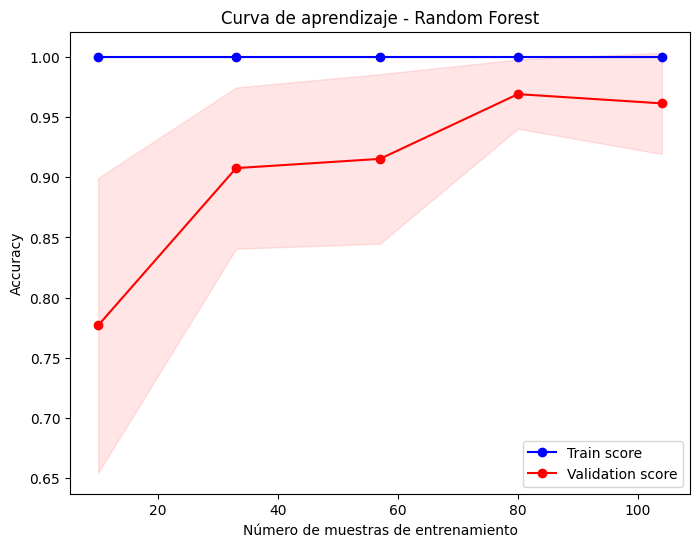

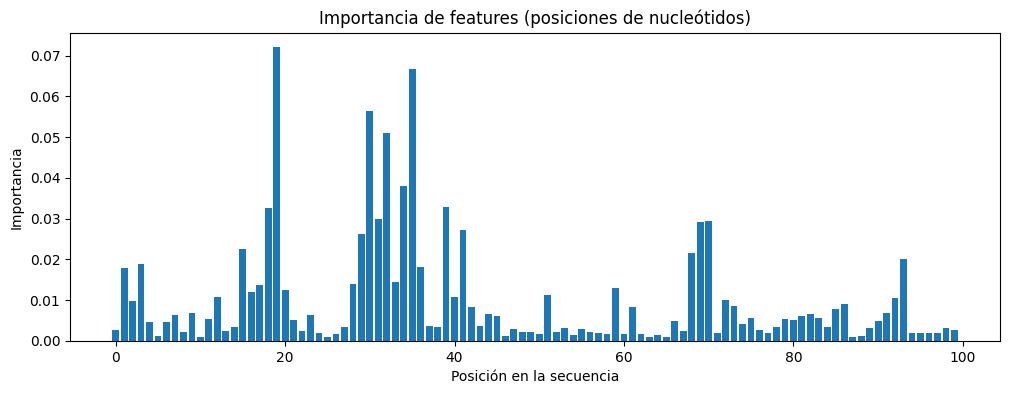

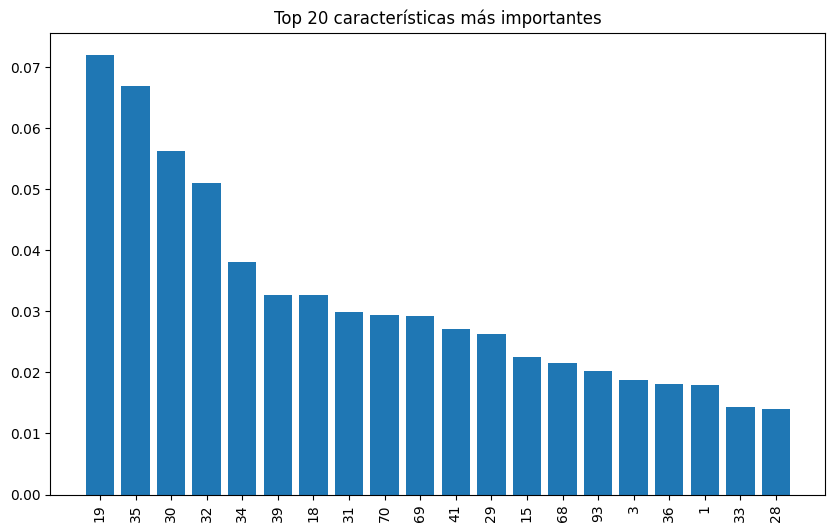

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ========================================
# 8. Definir mapping simple (solo secuencia)
# ========================================
rna_mapping = {'a': 0, 'u': 1, 'g': 2, 'c': 3}

def encode_sequence(seq, max_len):
    seq_vec = [rna_mapping.get(c.lower(), -1) for c in seq[:max_len]]
    while len(seq_vec) < max_len:
        seq_vec.append(-1)
    return seq_vec

# ========================================
# 9. Aplicar encoding a todas las secuencias
# ========================================
max_len = 100
features_seq = df["sequence"].apply(lambda s: encode_sequence(s, max_len))
features_df = pd.DataFrame(features_seq.tolist())

# ========================================
# 10. Normalización
# ========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# ========================================
# 11. Variable respuesta (clusters)
# ========================================
y = df["cluster_hierarchical"].values

# ========================================
# 12. Split en Train (70%), Validation+Test (30%)
# ========================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y
)

print(f"Tamaños -> Train: {X_train.shape}, Test: {X_test.shape}")

# ========================================
# 13. GridSearchCV con Random Forest
# ========================================

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_

# ========================================
# 14. Evaluación en Testset
# ========================================
y_test_pred = best_rf.predict(X_test)
print("\nTEST SET")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de confusión")
plt.show()

# ========================================
# 15. Curva de aprendizaje
# ========================================
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train score')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curva de aprendizaje - Random Forest')
plt.legend()
plt.show()

# ========================================
# 16. Importancia de características horizontal y top 20
# ========================================
importances = best_rf.feature_importances_
plt.figure(figsize=(12,4))
plt.bar(range(len(importances)), importances)
plt.xlabel('Posición en la secuencia')
plt.ylabel('Importancia')
plt.title('Importancia de features (posiciones de nucleótidos)')
plt.show()

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[indices][:20], align="center")
plt.xticks(range(20), indices[:20], rotation=90)
plt.title("Top 20 características más importantes")
plt.show()



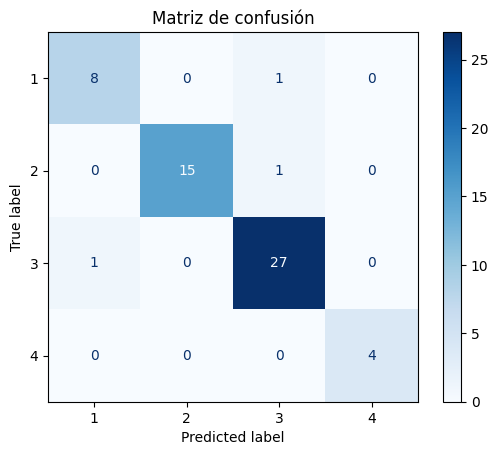

In [ ]:
# ========================================
# 17. Matriz de confusión
# ========================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de confusión")
plt.show()